In [1]:
%matplotlib inline

In [2]:
import numpy as np
import collections
import itertools
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.linalg
import scipy.stats
import functools
import json

#Regression

We have an 'unknown' function $y=f(x)$, and some (noisy) samples $(x_i, y_i)$. We want to use the samples to build a function $g(x)$ which matches $f(x)$ as closely as possible.

## Linear Least-Squares

Given a vector $P$ of training points $x_i$, we first create a design matrix $A$. Each row of the matrix transforms each datapoint $x_i$ with a different transformation function $a_k$.

$$A = \begin{pmatrix}
a_0(x_1) & a_0(x_2) & \cdots & a_0(x_P) \\
a_1(x_1) & a_1(x_2) & \cdots & a_1(x_P) \\
\vdots & \vdots & \ddots & \vdots \\
a_N(x_1) & a_N(x_2) & \cdots & a_N(x_P) \\
\end{pmatrix}$$

Given a weight for each row $w_k$, our fitted function computes an estimate of $y$ by a linear combination of $w_k$ and $a_k(x)$:

$$g(x_i) = \sum_{k=0}^N w_k a_k(x_i)$$

We want to find the coefficients $\mathbf{w}$ which fit the transformed training points $x_i$ close to the known $y_i$, (i.e. minimise the least-squares error). In an ideal world we could do this:

$$\begin{align}
A^T\mathbf{w} &= \mathbf{y} \\
\mathbf{w} &= (A^T)^{-1}\mathbf{y}\end{align}$$

But we cannot, because $A$ is probably not square. Instead, we use the pseudo-inverse of A:

$$\mathbf{w} = (AA^T)^{-1}A\mathbf{y}$$

(See adam's notes for the actual derivation of this)

Since this is a generalised method which can be applied to any kind of transformation function $a_k(x)$, we define a general class for performing linear least-squares fitting with any design matrix.

In [9]:
class LeastSquaresFitter(object):
    def pre_fit(self, X):
        """ A function which should do any fitting
        that's not part of least-squares. """
        pass
    
    def make_design_matrix(self, X):
        """ This function should take X and build the
        design matrix """
        raise "Override this method!"

    def fit(self, X, y):
        """ Build the design matrix for X and then compute
        the least-squares coefficient """
        self.pre_fit(X)
        A = self.make_design_matrix(X)
        self.coeffs = np.linalg.inv(A.dot(A.T)).dot(A).dot(y.T)
        
    def fit_with_weight_decay(self, X, y, decay):
        """ Fit with a weight decay term for regularisation """
        self.pre_fit(X)
        A = self.make_design_matrix(X)
        self.coeffs = np.linalg.inv(A.dot(A.T)+ decay * np.eye(A.shape[0])).dot(A).dot(y.T)

    def compute_components(self, X):
        """ Find w_k*a_k(x_i) for all i and k"""
        A = self.make_design_matrix(X)
        return A.T*self.coeffs
    
    def predict(self, X):
        """ For each point i in X, sum over w_k*a_k(x_i) 
        Thus giving the predicted values of all X
        """
        return np.sum(self.compute_components(X), axis=1)
    
    def plot_eval(self, x, y, fx, f, plot_components = True):
        """ Plot the fit """
        fy = f(fx)
        plt.plot(fx, fy, '--')
        plt.scatter(x, y, marker='x', c='k')
        plt.plot(fx[:-1], self.predict(fx[:-1]))
        plt.axis('tight')
        plt.legend(['Real', 'Fit','Training Data'], loc='best')
        plt.ylim((-0.4, 1.4))
        plt.show()
        
        
        if plot_components:
            curves = self.compute_components(fx)
            plt.plot(fx, self.predict(fx), linewidth=5)
            plt.plot(fx, curves[:, 1:] + curves[:, 0][0])
            plt.show()
    def gen_err(self, x, y):
        return np.mean((self.predict(x) - y)**2)
    def print_err(self, x, y):
        print "Generalisation Error: {}".format(self.gen_err(x, y))
        
    
    __call__ = predict


We define an 'unknown' function which we want to fit to:

$$ f(x) = \frac{1}{1 + \exp(-1.5x)} + \frac{1}{6}\sin(2x) $$

We only have some noisy samples, $x_i$ and $y_i$. We will try to fit $x_i$ to $y_i$ in the hope that the resulting function $g(x)$ closely approximates $f(x)$

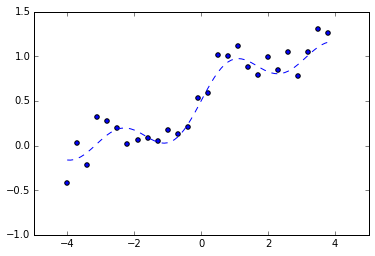

In [10]:
# Real function
def f(x):
    return 1.0 / (1.0 + np.exp(-1.5 * x)) + np.sin(x*2.0)/6.0
fx = np.arange(-4, 4, 0.1)
fy = f(fx)

# Generate the noisy samples
x = np.arange(-4, 4, 0.3)
y = f(x)+np.random.normal(loc=0, scale=0.15, size=len(x))

plt.plot(fx, fy, '--')
plt.scatter(x, y)
plt.show()

## Polynomial example
To fit a polynomial, the transformation function $a_k(x)$ is given by:

$$a_k(x) = x^k$$

And hence the resulting design matrix is:


$$A = \begin{pmatrix}
1 & 1 & \cdots & 1 \\
x_1 & x_2 & \cdots & x_P \\
x^2_1 & x^2_2 & \cdots & x^2_P \\
\vdots & \vdots & \ddots & \vdots \\
x^N_1 & x^N_2 & \cdots & x^N_P \\
\end{pmatrix}$$

Hence, each weight $w_k$ gives the contribution to the fit of a $k^{\mathrm{th}}$ order polynomial, and $w_0$ is the bias/offset term.

The 'Poly' class extends the LeastSquaresFitter class simply by describing implimenting the method for building the design matrix.

In [11]:
class Poly(LeastSquaresFitter):
    def __init__(self, order=5):
        self.coeffs = []
        self.order = order
        
    def make_design_matrix(self, x):
        return np.vstack([x**i for i in range(self.order+1)])

A degree-one polynomial just fits a line to the training data:

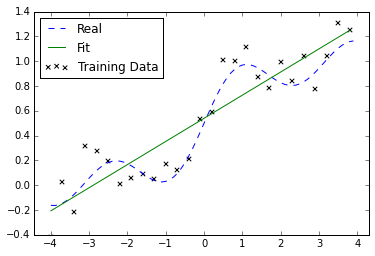

Generalisation Error: 0.0259347752883


In [12]:
# Define a polynomial fitter
poly = Poly(1)
# Solve with least squares
poly.fit(x, y)
# Plot the fit, and the components
poly.plot_eval(x, y, fx, f, plot_components=False)
poly.print_err(fx, f(fx))

Higher degree polynomials can fit more accurately. The second graph shows the contribution of each component (offset by the bias).

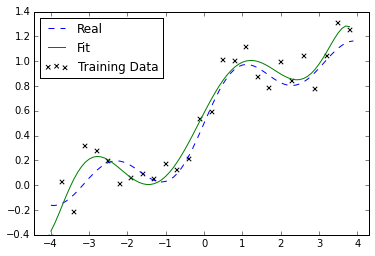

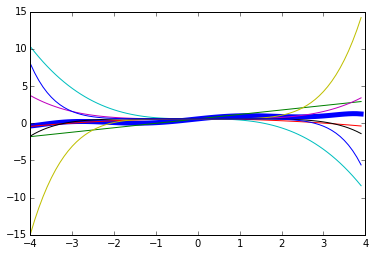

Generalisation Error: 0.00688829069056


In [13]:
# Define a polynomial fitter
poly = Poly(7)
# Solve with least squares
poly.fit(x, y)
# Plot the fit, and the components
poly.plot_eval(x, y, fx, f)
poly.print_err(fx, f(fx))

A polynomial of degree approaching $P$ should fit most of the training points, but that won't make it a good fit for the real function...

In practice, a $P$ degree polynomial doesn't actually seem to hit all the training points, probably due to numeric overflow or something

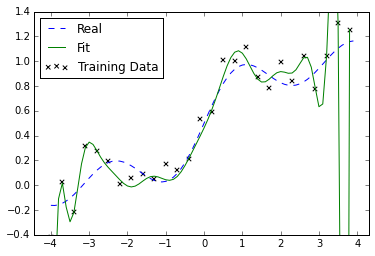

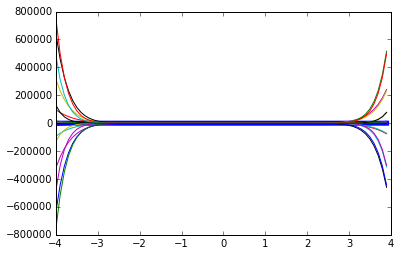

Generalisation Error: 69.9550324081


In [28]:
# Define a polynomial fitter
poly = Poly(20)
# Solve with least squares
poly.fit(x, y)
# Plot the fit, and the components
poly.plot_eval(x, y, fx, f)
poly.print_err(fx, f(fx))

## Radial basis function example
An alternative method is to find the distance of each $x_i$ to a number of centroids $c_k$, so $r = ||x_i - c_i||$. The transformation functions $a_k(x)$ are known as Radial Basis Functions if they are functions of $r$, for example:

$$\begin{align}
a_k(x) &= \exp\left(-\left(\frac{1}{\sigma}r\right)\right), \quad k\geq1 \\
a_0(x) &=1
\end{align}
$$

is the gaussian radial-basis function and a bias.

In [9]:
class RBF(LeastSquaresFitter):
    def __init__(self, centroids=5, sigma=1):
        self.centres = []
        self.coeffs = []
        self.centroids = centroids
        self.sigma = sigma
        
    def pre_fit(self, X):
        """Decide on the positions of the centroids, based on
        the range of x values in the training data """
        self.centres = np.arange(np.min(x), 
                         np.max(x)+0.1, 
                         (np.max(x) - np.min(x))/float(self.centroids))
        
    def make_design_matrix(self, x):
        bias = [np.ones(len(x))]
        phi = [np.exp(-((np.abs(x-c)/self.sigma)**2))
               for c in self.centres]
        r = np.vstack(bias + phi)
        return r

We see that each row of the design matrix specifies a guassian curve with a different centre, and the weights are chosen so that the sum of all the gaussians approximates $\mathbf{x}$. 

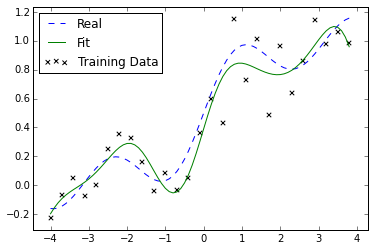

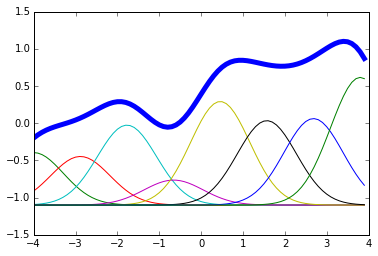

Generalisation Error: 0.0092258869624


In [10]:
rbf = RBF(centroids=7, sigma=1)
rbf.fit(x, y)
rbf.plot_eval(x, y, fx, f)
rbf.print_err(fx, f(fx))

The quality of the fit depends heavily on the number of centroids. With too few centroids, it's impossible to approximate $f(x)$.

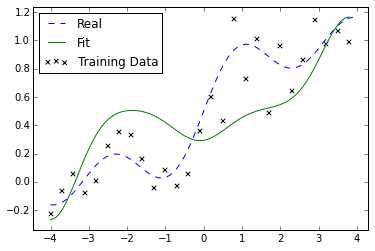

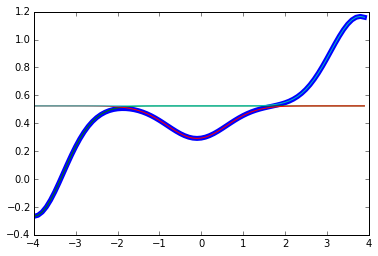

Generalisation Error: 0.0854422133127


In [11]:
rbf = RBF(centroids=2, sigma=1)
rbf.fit(x, y)
rbf.plot_eval(x, y, fx, f)
rbf.print_err(fx, f(fx))

With too many centroids, the algorithm overfits. The curve goes through every training point, generalisation error increases.

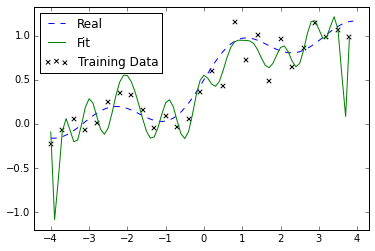

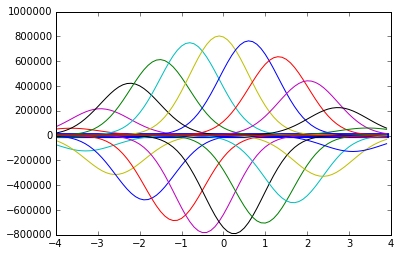

Generalisation Error: 0.338594076337


In [15]:
rbf = RBF(centroids=22, sigma=1)
rbf.fit(x, y)
rbf.plot_eval(x, y, fx, f)
rbf.print_err(fx, f(fx))

# Regularisation

## Linear weight decay

We can use regularisation to force the fit to be smoother. See Adam's notes for the derivation - thankfully his slides are actually comprehensible. 

The final form of the least-mean-squared solution is:

$$\mathbf{w} = (AA^T + \alpha I)^{-1}A\mathbf{y} $$

where $\alpha$ is a regularisation constant.

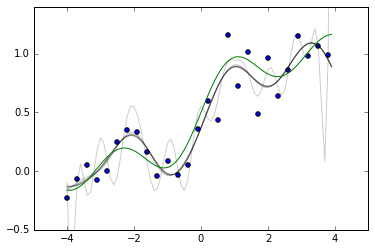

Generalisation Error: 0.00887645556062


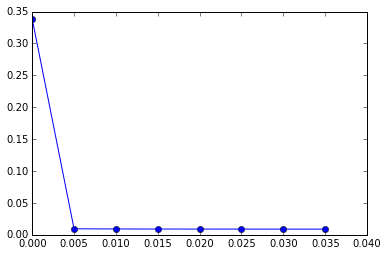

In [16]:
rbf = RBF(centroids=22, sigma=1)
errs = []
decays = np.arange(0, 0.04, 0.005)
for d in decays:
    rbf.fit_with_weight_decay(x, y, decay=d)
    plt.plot(fx, rbf(fx), c=(0, 0, 0, 0.2))
    errs.append(rbf.gen_err(fx, f(fx)))
plt.plot(fx, fy)
plt.scatter(x, y)
plt.ylim((-0.5, 1.4))
plt.show()
plt.plot(decays, errs, 'o-')
rbf.print_err(fx, f(fx))

This way we can just use a larger number of centroids -- not knowning exactly how many to use -- and regularisation will do the work of preventing overfitting problems.

## Tikhonov Regularisation

Nope, nope, nope nope nope. Hopefully this won't come up.